In [61]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from statsmodels.tsa.filters.hp_filter import hpfilter

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Layer, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
import random
import tensorflow as tf
import time

In [62]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [63]:
df = pd.read_csv('/content/drive/MyDrive/PLN_Timeseries/aa_442300169800_engineered.csv')
# df
# df['READ_DATE'] = pd.to_datetime(df['READ_DATE'])
# df.drop('READ_DATE_day', axis=1, inplace=True)
df

,READ_DATE,KWH_EXP,tavg,tmin,tmax,wdir,wspd,pres,Tavg,RH_avg,RR,ss,KWH_EXP_MA,KWH_EXP_ES,trend_ma,cycle_ma
0,2019-02-26,5.370424,29.1,24.5,35.0,130.0,7.5,1009.4,28.6,79.0,0.0,10.9,7.268577,5.440093,4.835155,2.433421
1,2019-02-27,5.944421,28.5,24.5,34.0,126.0,7.3,1007.9,28.7,78.0,0.0,11.6,7.268577,5.182594,4.835134,2.433442
2,2019-02-28,5.425158,28.2,24.8,33.2,120.0,7.2,1008.2,28.0,83.0,0.0,11.6,7.268577,6.557287,4.835114,2.433463
3,2019-03-01,5.506770,28.3,24.8,32.8,81.0,7.1,1008.5,28.0,80.0,0.0,6.1,7.268577,5.549410,4.835093,2.433484
4,2019-03-02,5.817964,28.4,24.4,32.6,100.0,6.7,1008.5,27.8,82.0,0.0,8.9,7.268577,5.131499,4.835072,2.433504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1917,2024-05-27,8.532623,28.3,24.4,34.0,126.0,9.9,1009.9,28.7,73.0,0.0,10.4,7.081333,8.346242,4.680875,2.400458
1918,2024-05-28,8.532623,28.2,24.1,33.9,125.0,8.0,1009.4,28.2,75.0,0.0,8.2,7.141727,8.532570,4.680841,2.460886
1919,2024-05-29,8.337785,29.0,24.2,33.0,130.0,7.7,1009.1,29.0,77.0,0.0,10.7,7.203475,9.660772,4.680807,2.522668
1920,2024-05-30,8.852736,29.7,25.0,35.0,106.0,7.8,1009.7,29.6,73.0,0.0,10.6,7.284493,7.384925,4.680772,2.603721


In [64]:
# # Menghitung nilai lambda untuk data harian berdasarkan aturan skala dari Ravn & Uhlig (2002)
# # Rumus umum:
# # lambda_new = lambda_base * (f_new / f_base) ** 4
# # Di mana:
# # - lambda_base = 1600 (untuk data kuartalan)
# # - f_base = 4 (frekuensi data kuartalan: 4 titik per tahun)
# # - f_new = 252 (jika hanya hari kerja) atau 365 (jika termasuk semua hari)

# # Perhitungan lambda untuk data harian (semua hari, 365 hari/tahun)
# lambda_daily_365 = 1600 * (365 / 4) ** 4  # Hasil: sekitar 69.3 x 10^9
# print(lambda_daily_365)
# # decompose menggunakan hpfilter
# cycle, trend = hpfilter(df['KWH_EXP_ES'], lamb=lambda_daily_365)
# df['trend_es'] = trend
# df['cycle_es'] = cycle

# # plot perbedaan data KWH_EXP dengan trend, KWH_EXP dengan cycle
# fig, ax = plt.subplots(2, 1, figsize=(12, 8))
# ax[0].plot(df['READ_DATE'], df['KWH_EXP_ES'], label='KWH_EXP_ES')
# ax[0].plot(df['READ_DATE'], df['trend_es'], label='Trend')
# ax[0].legend()

# ax[1].plot(df['READ_DATE'], df['KWH_EXP_ES'], label='KWH_EXP_ES')
# ax[1].plot(df['READ_DATE'], df['cycle_es'], label='Cycle')
# ax[1].legend()

# plt.show()


In [65]:
df.columns

Index(['READ_DATE', 'KWH_EXP', 'tavg', 'tmin', 'tmax', 'wdir', 'wspd', 'pres',
       'Tavg', 'RH_avg', 'RR', 'ss', 'KWH_EXP_MA', 'KWH_EXP_ES', 'trend_ma',
       'cycle_ma'],
      dtype='object')

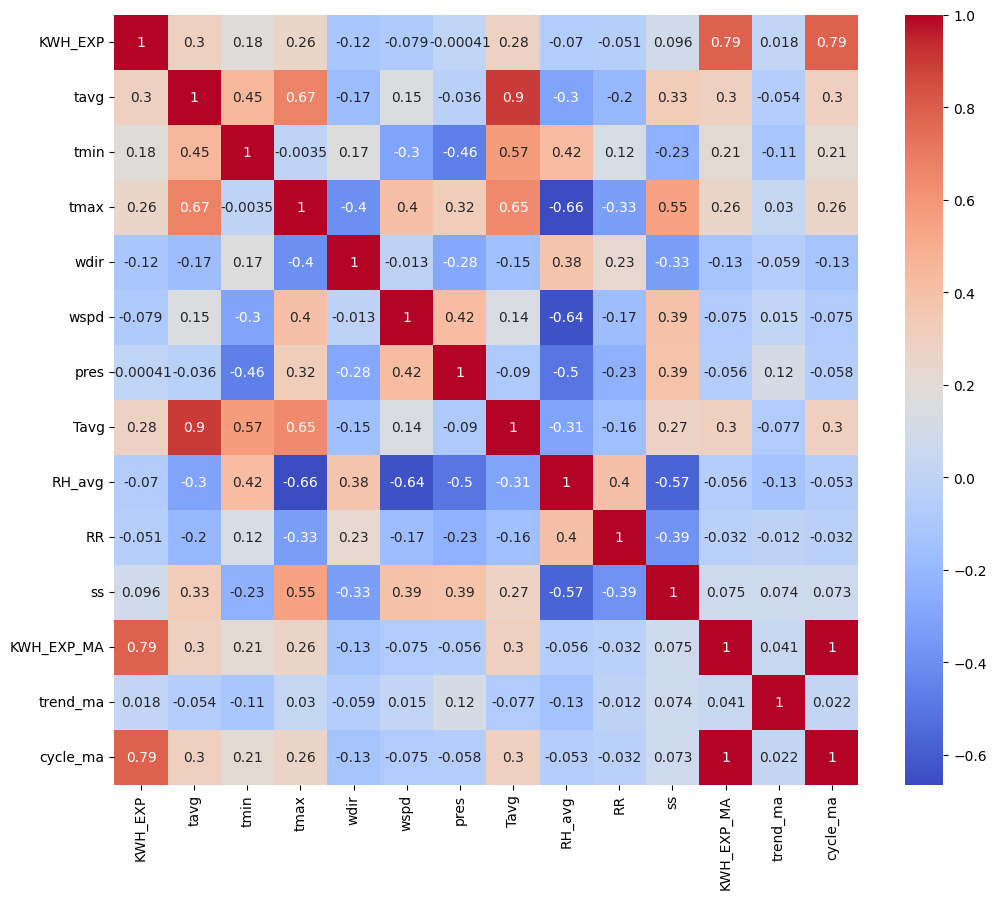

In [66]:
import seaborn as sns

# correlation plot
corr = df.copy()
# corr.drop(['READ_DATE', 'KWH_EXP_MA', 'trend_ma', 'cycle_ma'], axis=1, inplace=True)
corr.drop(['READ_DATE', 'KWH_EXP_ES'], axis=1, inplace=True)
corr = corr.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

In [67]:
df.set_index('READ_DATE', inplace=True)

# set es or ma pred

# df.drop(['KWH_EXP_ES', 'KWH_EXP', 'trend_es', 'cycle_es'], axis=1, inplace=True)
# df.drop(['KWH_EXP_ES', 'KWH_EXP', 'trend_ma', 'cycle_ma'], axis=1, inplace=True)
df.drop(['KWH_EXP_ES', 'KWH_EXP', 'RR', 'pres', 'wspd', 'RH_avg', 'ss', 'trend_ma'], axis=1, inplace=True)
df.columns

Index(['tavg', 'tmin', 'tmax', 'wdir', 'Tavg', 'KWH_EXP_MA', 'cycle_ma'], dtype='object')

In [68]:
# split data train dan test. 3 tahun pertama untuk train, 2 tahun terakhir untuk test
"""
READ_DATE
2019-01-01	11.001903	25.7	24.8	30.2	44.0	6.4	1008.9
2019-01-02	11.422662	26.0	24.1	29.2	21.0	5.4	1009.2
2019-01-03	2.341671	24.6	24.0	27.3	340.0	4.1	1010.3
2019-01-04	4.800008	26.2	23.0	29.8	340.0	6.9	1011.4
2019-01-05	5.752651	26.9	23.6	30.2	284.0	6.3	1011.7
...	...	...	...	...	...	...	...
2024-05-27	2.381903	28.3	24.4	34.0	126.0	9.9	1009.9
2024-05-28	2.412923	28.2	24.1	33.9	125.0	8.0	1009.4
2024-05-29	2.564494	29.0	24.2	33.0	130.0	7.7	1009.1
# 2024-05-30	2.558021	29.7	25.0	35.0	106.0	7.8	1009.7
2024-05-31	2.457463	29.8	25.5	35.2	121.0	9.6	1010.4
"""
train = df.loc['2019-01-01':'2022-12-31']
test = df.loc['2023-01-01':'2024-05-24']
real_sim = df.loc['2024-05-25':'2024-05-31']

In [69]:
# Scale data
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

train_scaled_features = feature_scaler.fit_transform(train)
train_scaled_target = target_scaler.fit_transform(train[['KWH_EXP_MA']])
test_scaled_features = feature_scaler.transform(test)
test_scaled_target = target_scaler.transform(test[['KWH_EXP_MA']])

# train_scaled_features = feature_scaler.fit_transform(train)
# train_scaled_target = target_scaler.fit_transform(train[['KWH_EXP_ES']])
# test_scaled_features = feature_scaler.transform(test)
# test_scaled_target = target_scaler.transform(test[['KWH_EXP_ES']])


In [70]:
train_scaled_features

array([[ 1.48845838,  0.7822    ,  1.19831544, ...,  1.17633583,
         0.8888511 ,  0.87207234],
       [ 0.91602662,  0.7822    ,  0.6056538 , ...,  1.26986516,
         0.8888511 ,  0.87207947],
       [ 0.62981074,  1.01487276,  0.13152448, ...,  0.61515983,
         0.8888511 ,  0.87208661],
       ...,
       [-1.564511  ,  0.54952724, -1.64646044, ..., -1.25542683,
        -1.30340146, -1.27787858],
       [-1.564511  ,  0.39441207, -3.3651792 , ..., -2.28424949,
        -1.29773584, -1.27218058],
       [-0.22883689,  1.01487276, -0.87600031, ...,  0.61515983,
        -1.29441215, -1.26882888]])

In [71]:
# Daftar timestep yang akan diuji
timesteps_list = [1, 2, 3, 4, 5, 6, 7]

In [72]:
def plot_predictions(model, X_test_t, y_test_t, scaler, timesteps, model_name, real_sim, n_future=7):
    # Make predictions
    y_pred = model.predict(X_test_t)
    y_test_orig = target_scaler.inverse_transform(y_test_t.reshape(-1, 1))
    y_pred_orig = target_scaler.inverse_transform(y_pred)

    # Create DataFrame for Actual vs Predicted
    results_df = pd.DataFrame({
        'Actual': y_test_orig.flatten(),
        'Predicted': y_pred_orig.flatten()
    })

    # Save DataFrame to CSV with model name and timesteps
    file_name = f"{model_name}_timestep_{timesteps}_actual_vs_pred.csv"
    results_df.to_csv(file_name, index=False)
    print(f"Results saved to {file_name}")

    # Plot Actual vs Predicted
    plt.figure(figsize=(15, 8))
    plt.subplot(2, 1, 1)
    plt.plot(results_df['Actual'], label='Actual', alpha=0.8)
    plt.plot(results_df['Predicted'], label='Predicted', alpha=0.8)
    plt.title(f'Actual vs Predicted (Timesteps={timesteps})')
    plt.xlabel('Time')
    plt.ylabel('KWH_EXP_ES')
    plt.legend()
    plt.grid(True)

    # Generate future predictions
    last_sequence = X_test_t[-1:]
    future_pred = []

    for _ in range(n_future):
        next_pred = model.predict(last_sequence)
        future_pred.append(next_pred[0])

        last_sequence = np.roll(last_sequence, -1, axis=1)
        last_sequence[0, -1] = next_pred[0]

    future_pred = target_scaler.inverse_transform(np.array(future_pred).reshape(-1, 1))

    # Combine test + real_sim and test + n_future predictions
    combined_actual = np.concatenate((y_test_orig.flatten(), real_sim['KWH_EXP_MA'].values))
    combined_predicted = np.concatenate((y_test_orig.flatten(), future_pred.flatten()))

    # Limit scope to the last part of the data
    scope_start = max(0, len(combined_actual) - (n_future + 28))
    scoped_actual = combined_actual[scope_start:]
    scoped_predicted = combined_predicted[scope_start:]

    # Plot Comparison
    plt.subplot(2, 1, 2)
    plt.plot(range(len(scoped_actual)), scoped_actual, label='Test + Real Sim', alpha=0.8)
    plt.plot(range(len(scoped_predicted)), scoped_predicted, label='Test + Predicted Future', alpha=0.8)
    plt.title('Comparison of Real Simulation vs Predicted Future (Zoomed In)')
    plt.xlabel('Time')
    plt.ylabel('KWH_EXP')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    mse = mean_squared_error(y_test_orig, y_pred_orig)
    r2 = r2_score(y_test_orig, y_pred_orig)
    mape = mean_absolute_percentage_error(y_test_orig, y_pred_orig)
    mae = mean_absolute_error(y_test_orig, y_pred_orig)
    print(f"\nMetrics for timesteps={timesteps}:")
    print(f"MSE: {mse:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"MAPE: {mape:.4f}")
    print(f"MAE: {mae:.4f}")



def train_and_plot_bilstm(X_train, y_train, X_test, y_test, timesteps, real_sim):
    def create_dataset(X, y, time_steps=1):
      Xs, ys = [], []
      for i in range(len(X) - time_steps):
          v = X[i:(i + time_steps)]
          Xs.append(v)
          ys.append(y[i + time_steps])
      return np.array(Xs), np.array(ys)

    X_train_t, y_train_t = create_dataset(X_train, y_train, timesteps)
    X_test_t, y_test_t = create_dataset(X_test, y_test, timesteps)

    model = Sequential([
        Input(shape=(timesteps, X_train.shape[1])),
        Bidirectional(LSTM(128, return_sequences=True)),
        Bidirectional(LSTM(64)),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')

    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        mode='min',
        verbose=1
    )

    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=0.001,
        verbose=1
    )

    model.fit(
        X_train_t,
        y_train_t,
        validation_split=0.1,
        epochs=50,
        batch_size=512,
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )

    plot_predictions(model, X_test_t, y_test_t, target_scaler, timesteps, model_name="bilstm", real_sim=real_sim, n_future=7)



Training model with selected features and timesteps = 1
Epoch 23: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
Results saved to bilstm_timestep_1_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


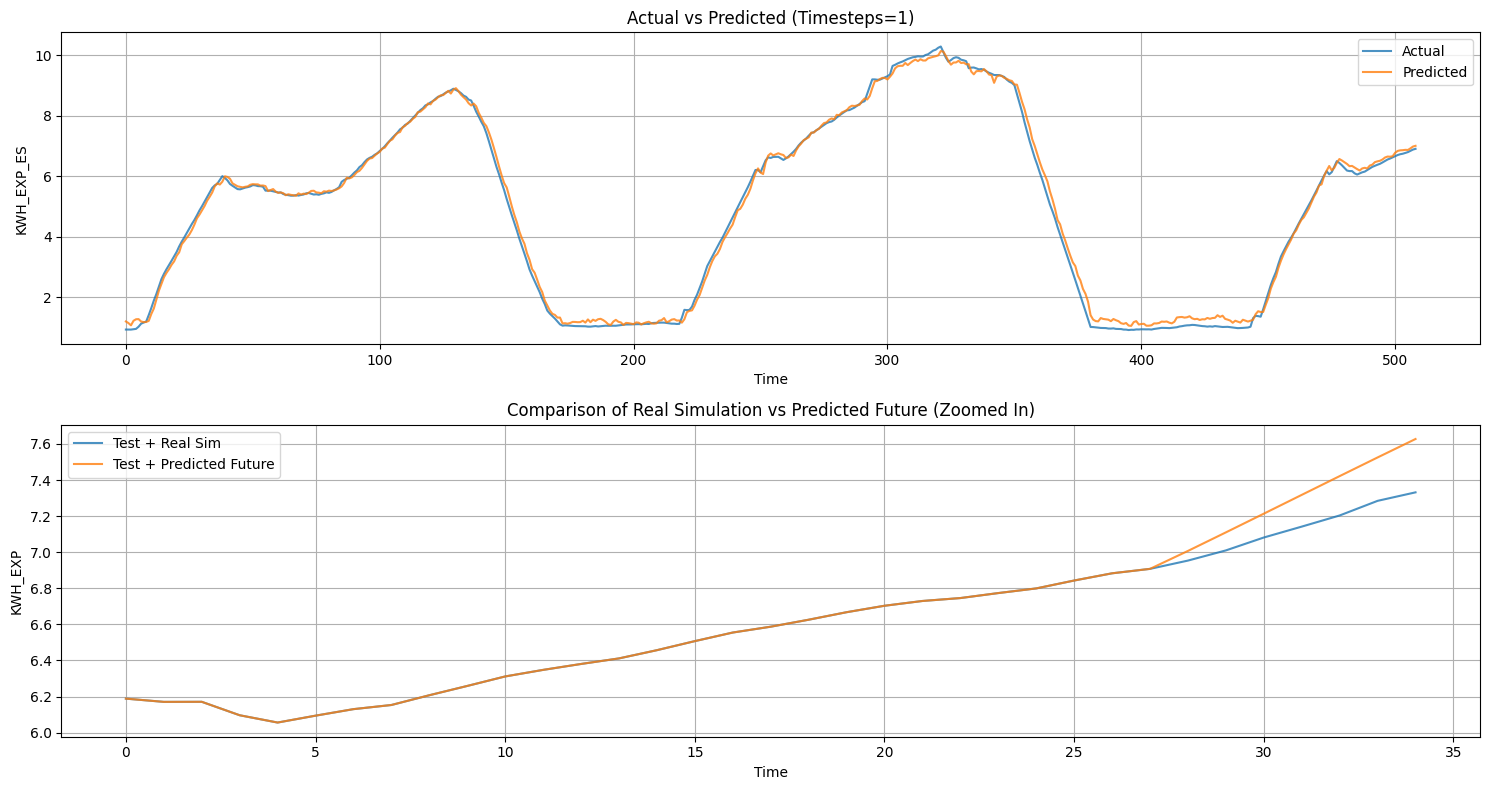


Metrics for timesteps=1:
MSE: 0.0311
R²: 0.9965
MAPE: 0.0656
MAE: 0.1390
Training time for timesteps = 1: 9.48 seconds

Training model with selected features and timesteps = 2
Epoch 16: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
Results saved to bilstm_timestep_2_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


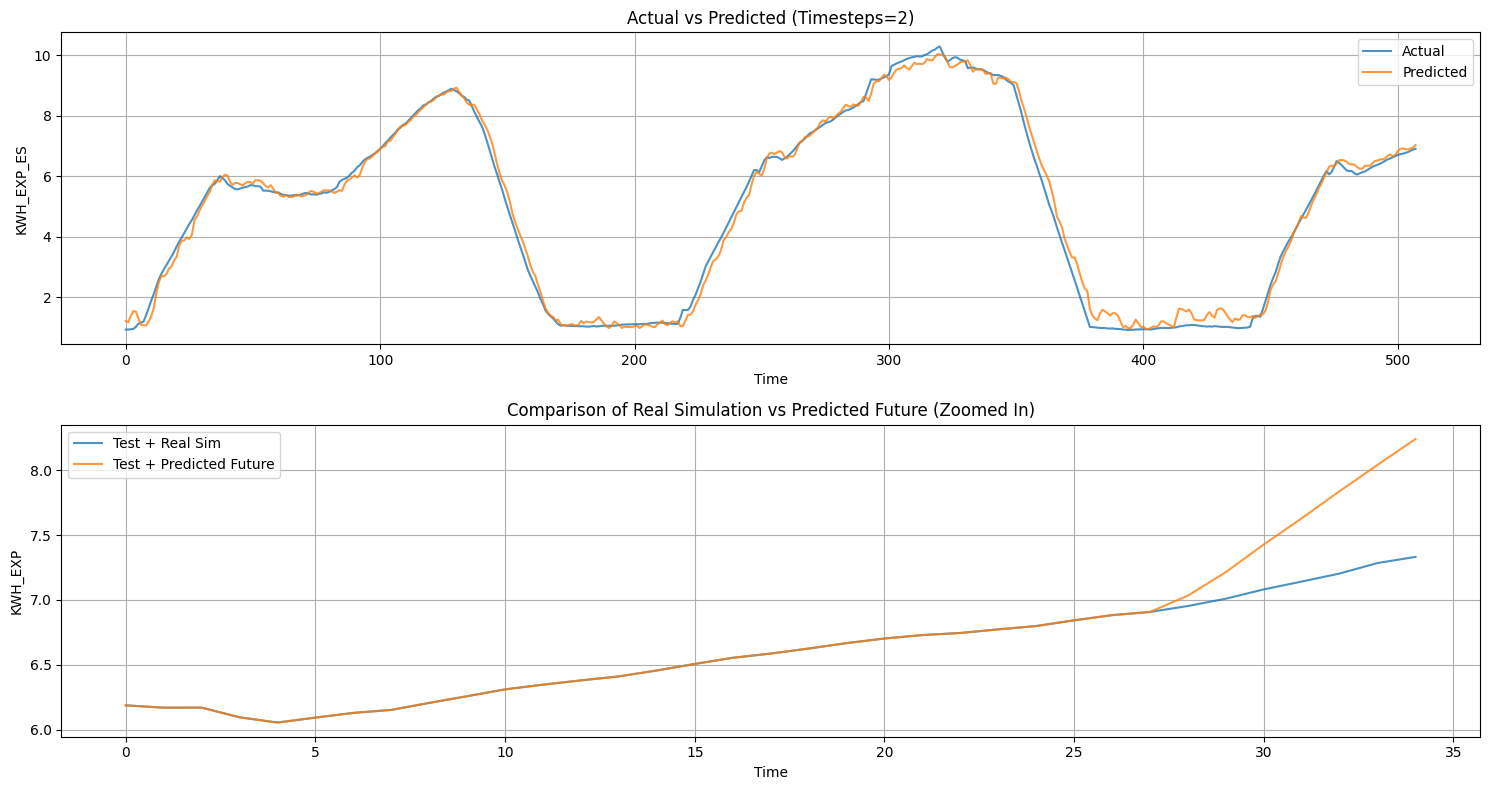


Metrics for timesteps=2:
MSE: 0.0693
R²: 0.9923
MAPE: 0.0868
MAE: 0.2001
Training time for timesteps = 2: 8.59 seconds

Training model with selected features and timesteps = 3
Epoch 13: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Results saved to bilstm_timestep_3_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


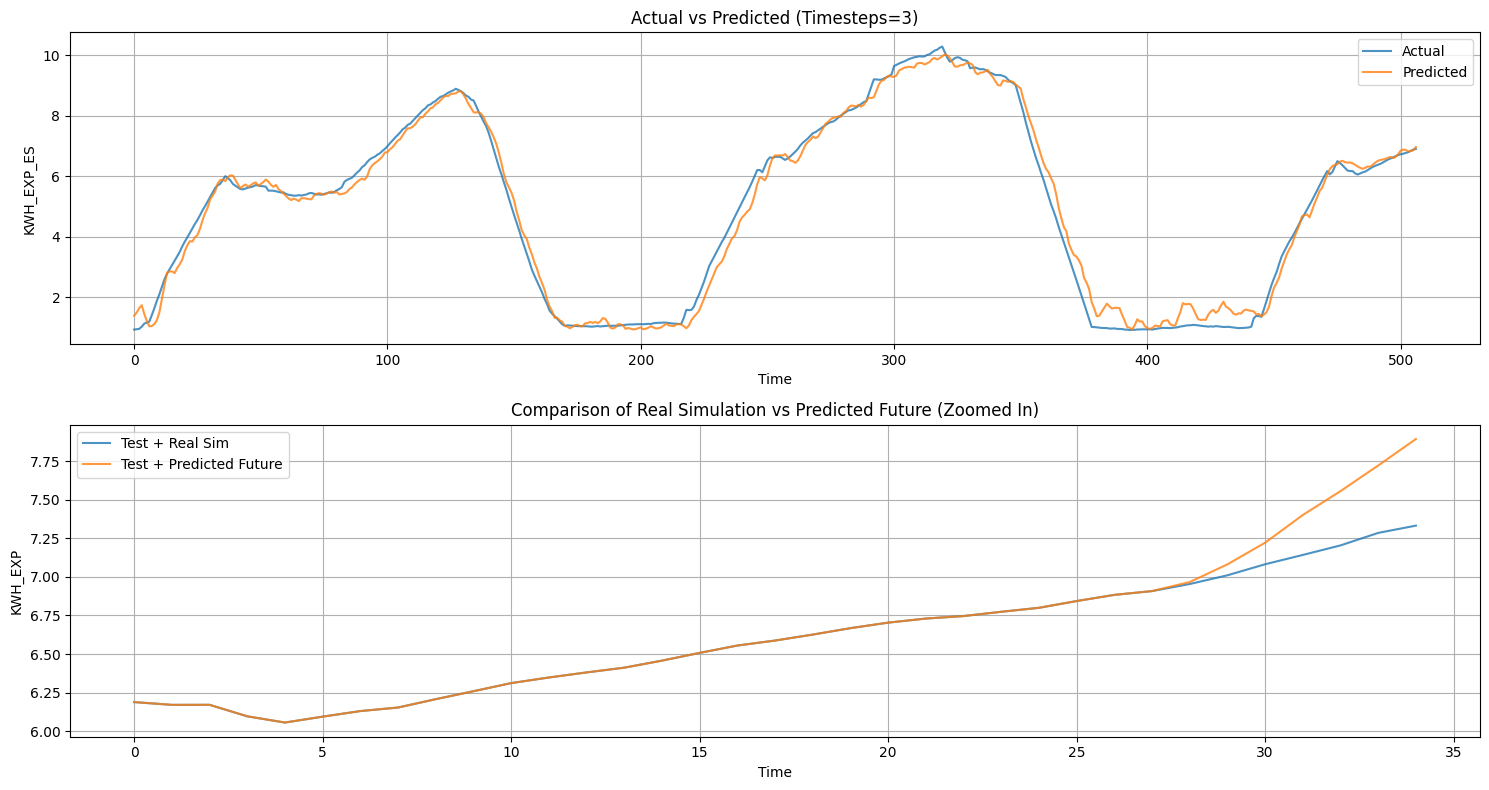


Metrics for timesteps=3:
MSE: 0.1140
R²: 0.9873
MAPE: 0.1139
MAE: 0.2606
Training time for timesteps = 3: 8.06 seconds

Training model with selected features and timesteps = 4
Epoch 12: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Results saved to bilstm_timestep_4_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


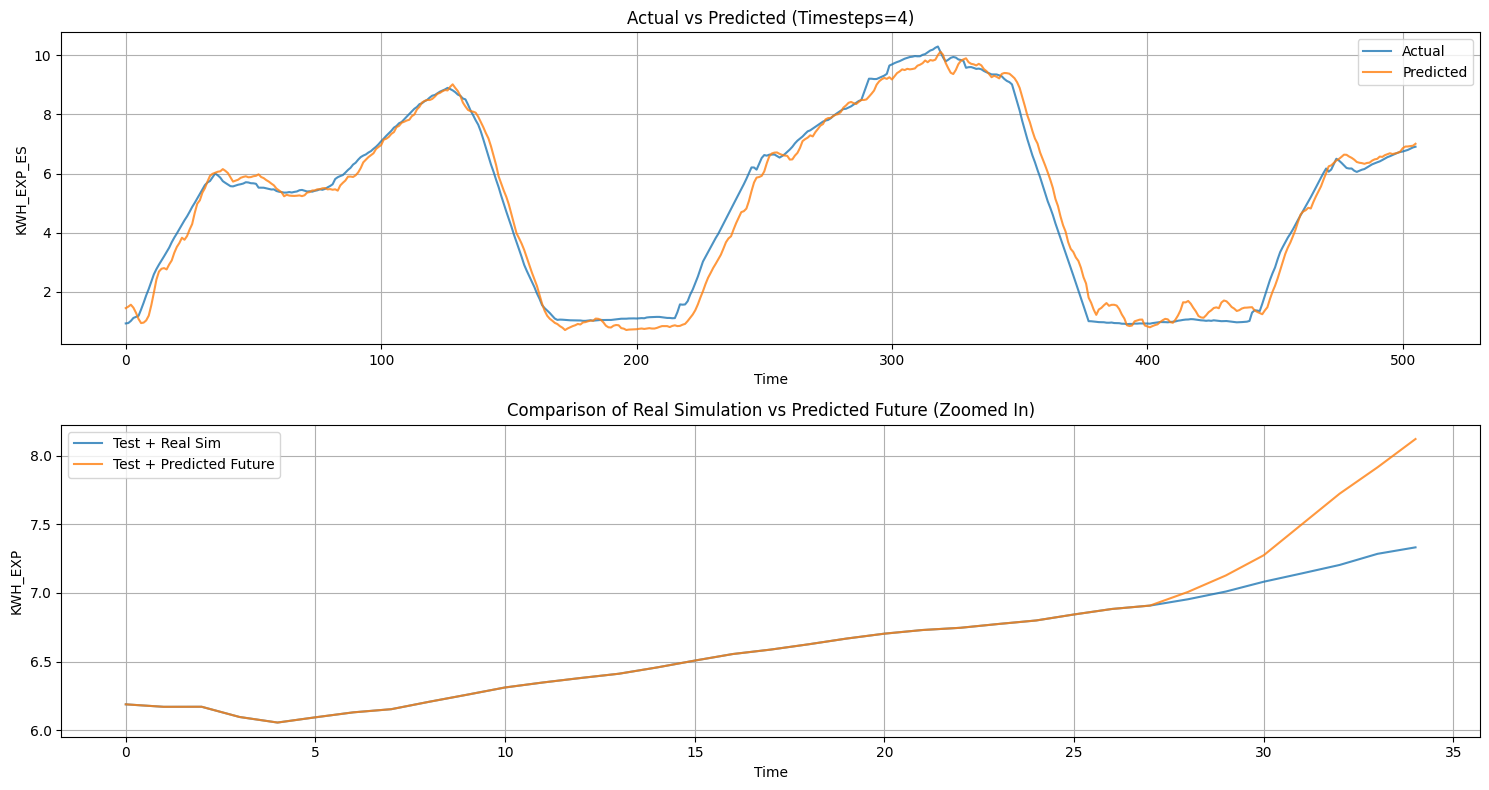


Metrics for timesteps=4:
MSE: 0.1686
R²: 0.9812
MAPE: 0.1288
MAE: 0.3186
Training time for timesteps = 4: 8.88 seconds

Training model with selected features and timesteps = 5
Epoch 11: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
Results saved to bilstm_timestep_5_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


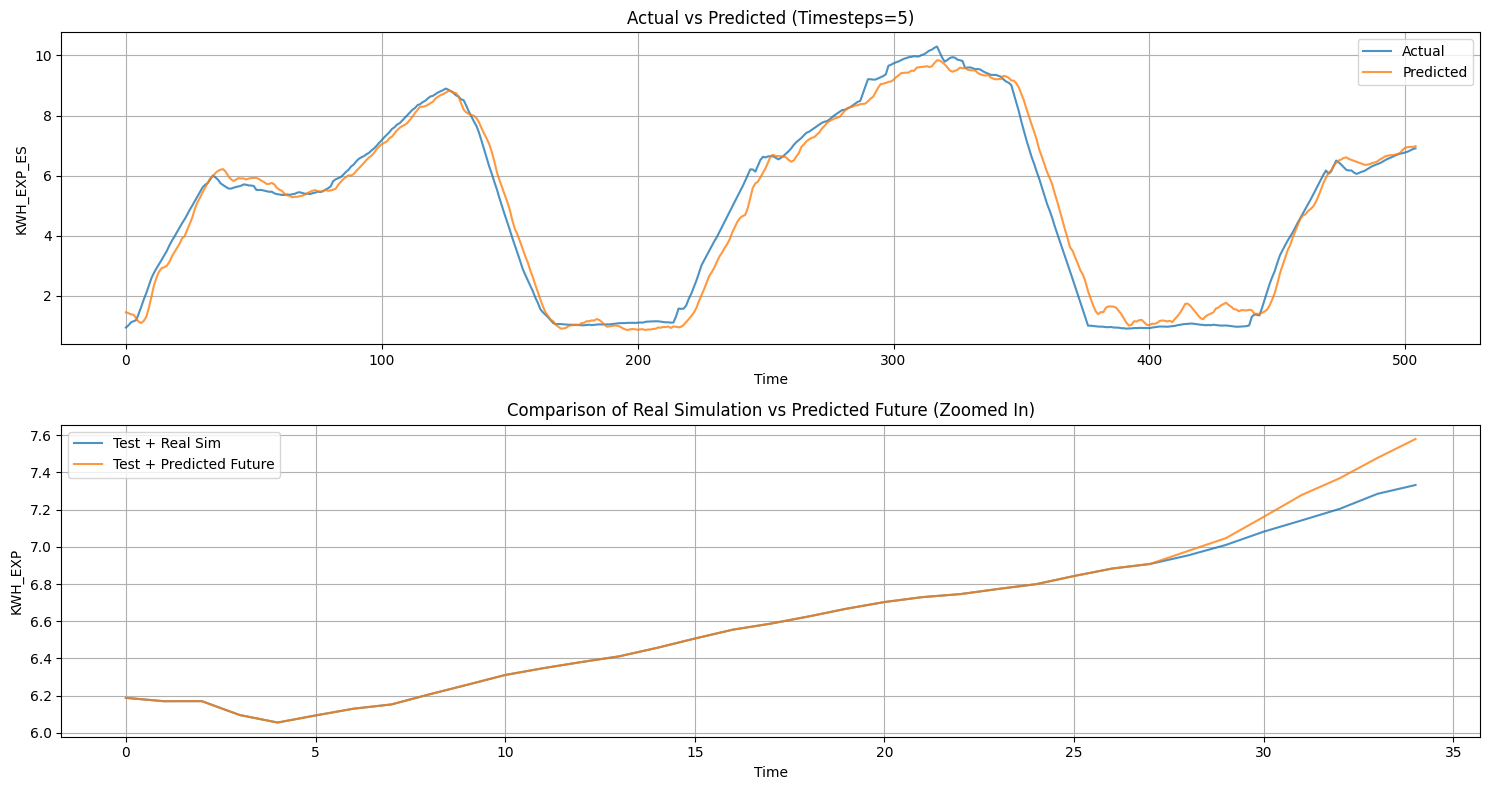


Metrics for timesteps=5:
MSE: 0.2056
R²: 0.9770
MAPE: 0.1364
MAE: 0.3525
Training time for timesteps = 5: 8.01 seconds

Training model with selected features and timesteps = 6
Epoch 10: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Results saved to bilstm_timestep_6_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


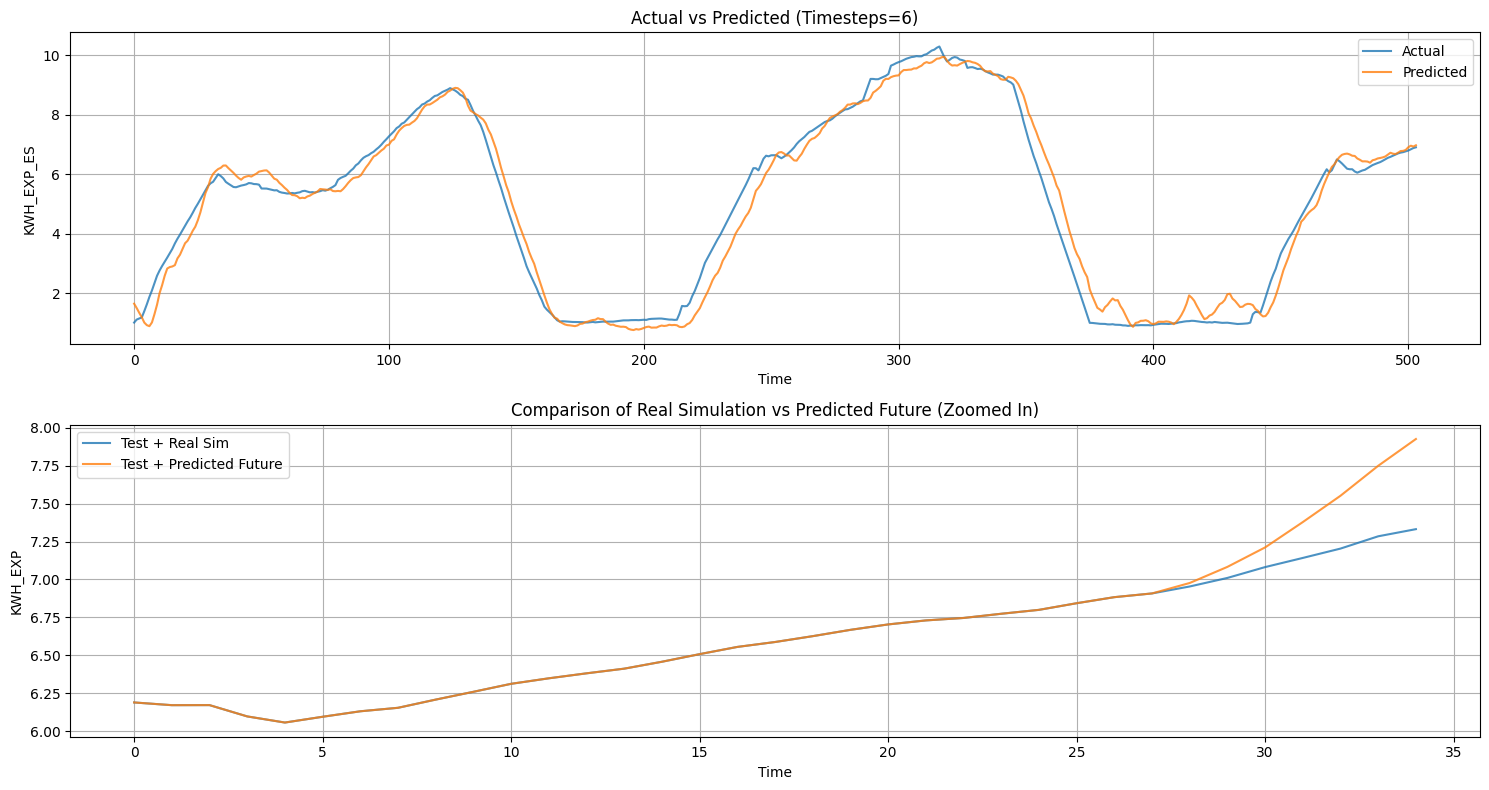


Metrics for timesteps=6:
MSE: 0.2651
R²: 0.9703
MAPE: 0.1510
MAE: 0.3949
Training time for timesteps = 6: 6.51 seconds

Training model with selected features and timesteps = 7
Epoch 10: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Results saved to bilstm_timestep_7_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


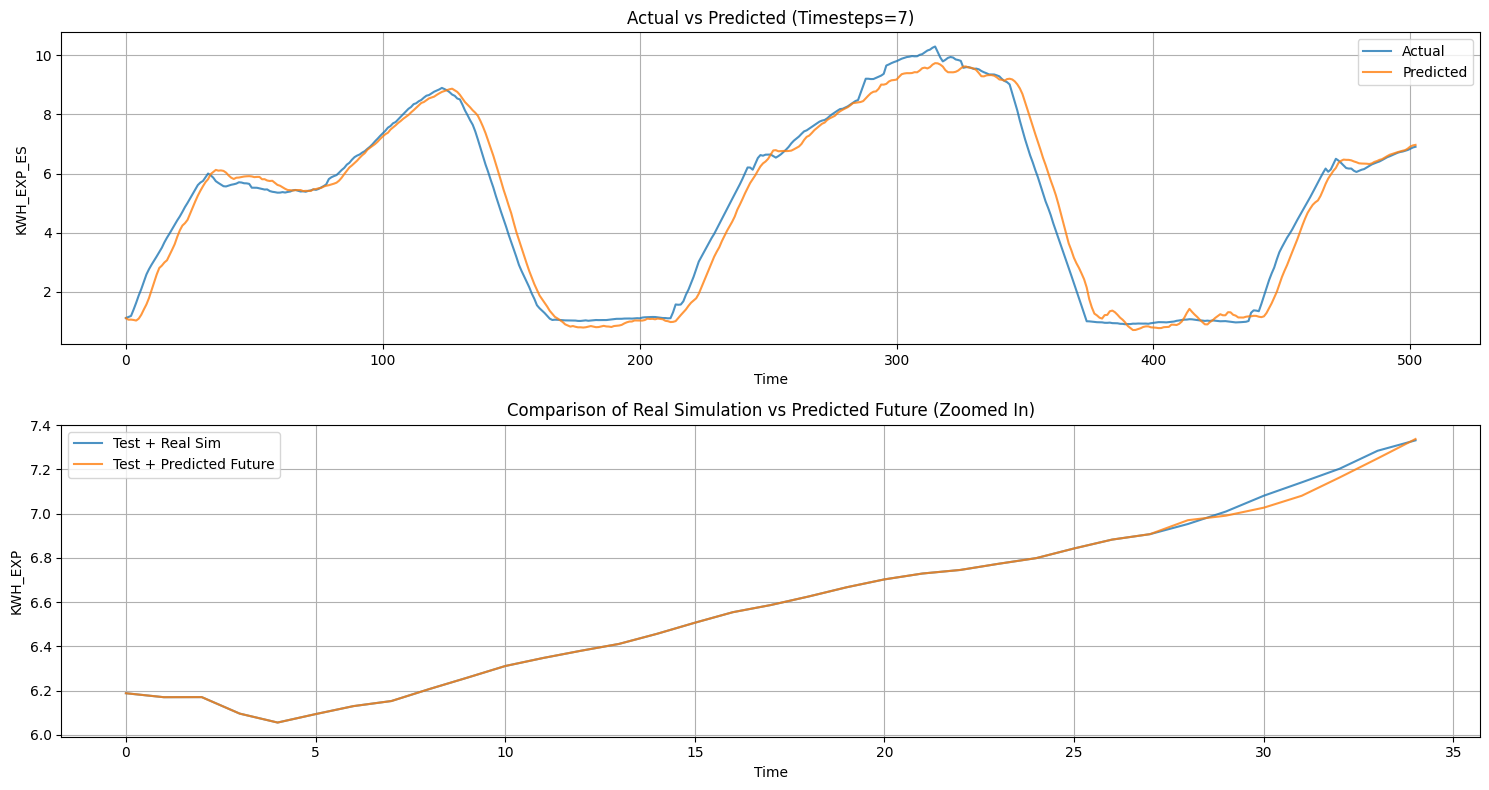


Metrics for timesteps=7:
MSE: 0.2410
R²: 0.9730
MAPE: 0.1193
MAE: 0.3658
Training time for timesteps = 7: 7.39 seconds
Total training execution time: 56.93 seconds


In [73]:
total_training_start_time = time.time()
for ts in timesteps_list:

    print(f"\nTraining model with selected features and timesteps = {ts}")
    training_start_time = time.time()
    train_and_plot_bilstm(train_scaled_features, train_scaled_target.ravel(), test_scaled_features, test_scaled_target.ravel(), ts, real_sim)
    training_end_time = time.time()
    print(f"Training time for timesteps = {ts}: {training_end_time - training_start_time:.2f} seconds")

total_training_end_time = time.time()
print(f"Total training execution time: {total_training_end_time - total_training_start_time:.2f} seconds")

In [74]:
# Fungsi untuk membuat model LSTM atau BiLSTM
def create_model(input_shape, model_type='lstm'):
    model = Sequential()
    model.add(Input(shape=input_shape))
    if model_type == 'bilstm':
        model.add(Bidirectional(LSTM(128, return_sequences=True)))
        model.add(Bidirectional(LSTM(64)))
    else:
        model.add(LSTM(128, return_sequences=True))
        model.add(LSTM(64))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Fungsi untuk membuat dataset dengan timestep
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# Fungsi untuk evaluasi kromosom
def evaluate_chromosome(chromosome, X_train, y_train, X_test, y_test, timesteps, model_type='lstm'):
    selected_features = [i for i in range(len(chromosome)) if chromosome[i] == 1]
    X_train_selected = X_train[:, selected_features]
    X_test_selected = X_test[:, selected_features]

    X_train_t, y_train_t = create_dataset(X_train_selected, y_train, timesteps)
    X_test_t, y_test_t = create_dataset(X_test_selected, y_test, timesteps)

    model = create_model((X_train_t.shape[1], X_train_t.shape[2]), model_type)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)

    model.fit(X_train_t, y_train_t, epochs=10, validation_split=0.1, callbacks=[early_stopping], verbose=0)
    y_pred = model.predict(X_test_t)
    mse = mean_squared_error(y_test_t, y_pred)
    mae = mean_absolute_error(y_test_t, y_pred)
    r2 = r2_score(y_test_t, y_pred)
    mape = mean_absolute_percentage_error(y_test_t, y_pred)

    print(f"Evaluating chromosome {chromosome} -> MSE: {mse}, MAE: {mae}, R²: {r2}, MAPE: {mape}")
    return mse

# Fungsi untuk inisialisasi populasi
def initialize_population(pop_size, num_features):
    population = [np.random.randint(2, size=num_features) for _ in range(pop_size - 1)]
    # Tambahkan satu kromosom yang memiliki semua fitur diaktifkan
    population.append(np.ones(num_features, dtype=int))
    print(f"Initialized population: {population}")
    return population

# Fungsi untuk seleksi
def select(population, fitnesses, num_parents):
    indices = np.argsort(fitnesses)[:num_parents]
    parents = [population[i] for i in indices]
    print(f"Selected parents: {parents}")
    return parents

# Fungsi untuk crossover
def crossover(parents, offspring_size):
    offspring = []
    for _ in range(offspring_size):
        parent1, parent2 = random.sample(list(parents), 2)
        crossover_point = random.randint(1, len(parent1)-1)
        child = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
        offspring.append(child)
        print(f"Crossover between {parent1} and {parent2} at {crossover_point} -> {child}")
    return offspring

# Fungsi untuk mutasi
def mutate(offspring, mutation_rate):
    for child in offspring:
        if random.random() < mutation_rate:
            mutation_point = random.randint(0, len(child)-1)
            child[mutation_point] = 1 - child[mutation_point]
            print(f"Mutated child {child} at {mutation_point}")
    return offspring

# Main GA function
def genetic_algorithm(X, y, timesteps_list, pop_size=5, num_generations=3, mutation_rate=0.1):
    num_features = X.shape[1]
    best_chromosomes = {}
    total_start_time = time.time()

    for timesteps in timesteps_list:
        print(f"\nRunning GA for feature selection with timesteps = {timesteps}")
        population = initialize_population(pop_size, num_features)
        start_time = time.time()

        for generation in range(num_generations):
            generation_start_time = time.time()
            fitnesses = np.array([evaluate_chromosome(chrom, X, y, X, y, timesteps) for chrom in population])
            best_fitness = np.min(fitnesses)
            best_chromosome = population[np.argmin(fitnesses)]

            parents = select(population, fitnesses, pop_size//2)
            offspring = crossover(parents, pop_size - len(parents))
            offspring = mutate(offspring, mutation_rate)
            population = np.concatenate((parents, offspring))

            generation_end_time = time.time()
            print(f"Generation {generation}: Best Fitness = {best_fitness}")
            print(f"Best Chromosome: {best_chromosome}")
            print(f"Population: {population}")
            print(f"Execution time for generation {generation}: {generation_end_time - generation_start_time:.2f} seconds")

        end_time = time.time()
        best_chromosomes[timesteps] = best_chromosome
        print(f"Best Features for timesteps = {timesteps}: {best_chromosome}")
        print(f"Execution time for timesteps {timesteps}: {end_time - start_time:.2f} seconds")

    total_end_time = time.time()
    print(f"Total execution time for GA: {total_end_time - total_start_time:.2f} seconds")

    return best_chromosomes

In [75]:
def train_and_plot_lstm(X_train, y_train, X_test, y_test, timesteps, real_sim):
    def create_dataset(X, y, time_steps=1):
      Xs, ys = [], []
      for i in range(len(X) - time_steps):
          v = X[i:(i + time_steps)]
          Xs.append(v)
          ys.append(y[i + time_steps])
      return np.array(Xs), np.array(ys)

    X_train_t, y_train_t = create_dataset(X_train, y_train, timesteps)
    X_test_t, y_test_t = create_dataset(X_test, y_test, timesteps)

    model = Sequential([
        Input(shape=(timesteps, X_train.shape[1])),
        LSTM(128, return_sequences=True),
        LSTM(64),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')

    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        mode='min',
        verbose=1
    )

    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=0.001,
        verbose=1
    )

    model.fit(
        X_train_t,
        y_train_t,
        validation_split=0.1,
        epochs=50,
        batch_size=512,
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )

    plot_predictions(model, X_test_t, y_test_t, target_scaler, timesteps, model_name="lstm", real_sim=real_sim, n_future=7)


In [76]:
# Daftar timestep yang akan diuji
timesteps_list = [1, 2, 3, 4, 5, 6, 7]



Training model with selected features and timesteps = 1
Epoch 30: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Results saved to lstm_timestep_1_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


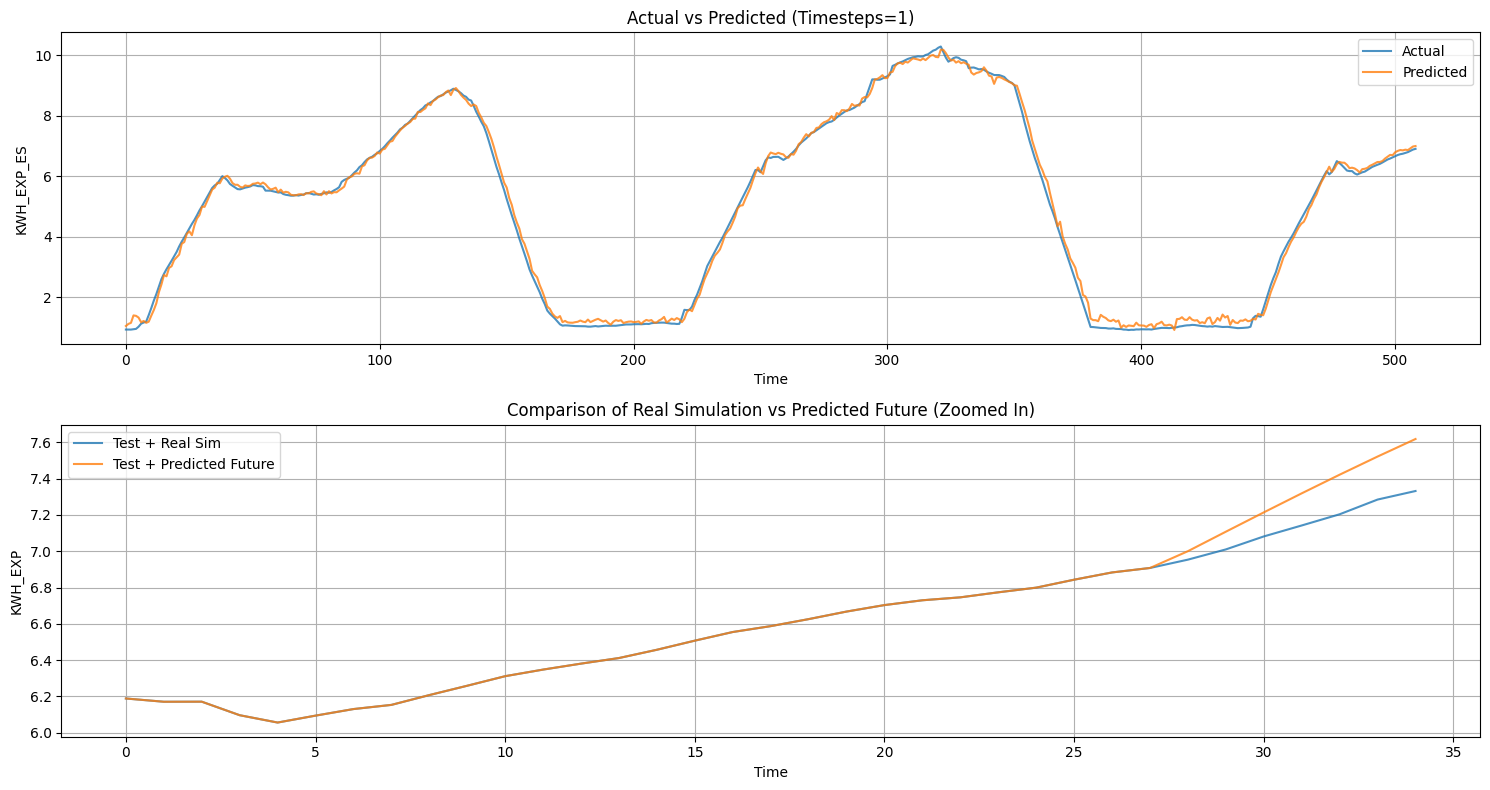


Metrics for timesteps=1:
MSE: 0.0302
R²: 0.9966
MAPE: 0.0641
MAE: 0.1405
Training time for timesteps = 1: 6.31 seconds

Training model with selected features and timesteps = 2
Epoch 21: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Results saved to lstm_timestep_2_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


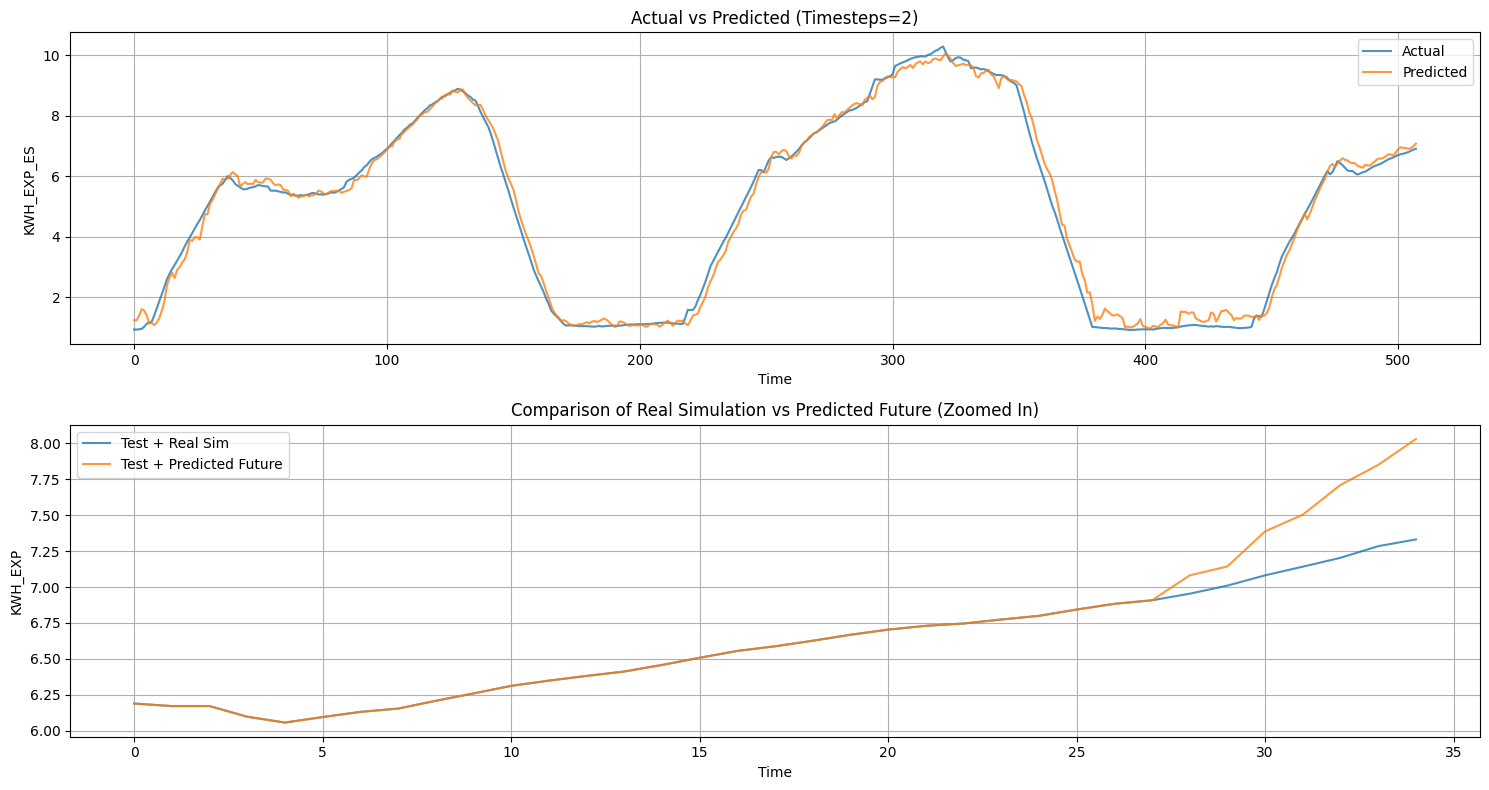


Metrics for timesteps=2:
MSE: 0.0812
R²: 0.9910
MAPE: 0.0900
MAE: 0.2181
Training time for timesteps = 2: 6.96 seconds

Training model with selected features and timesteps = 3
Epoch 16: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Results saved to lstm_timestep_3_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


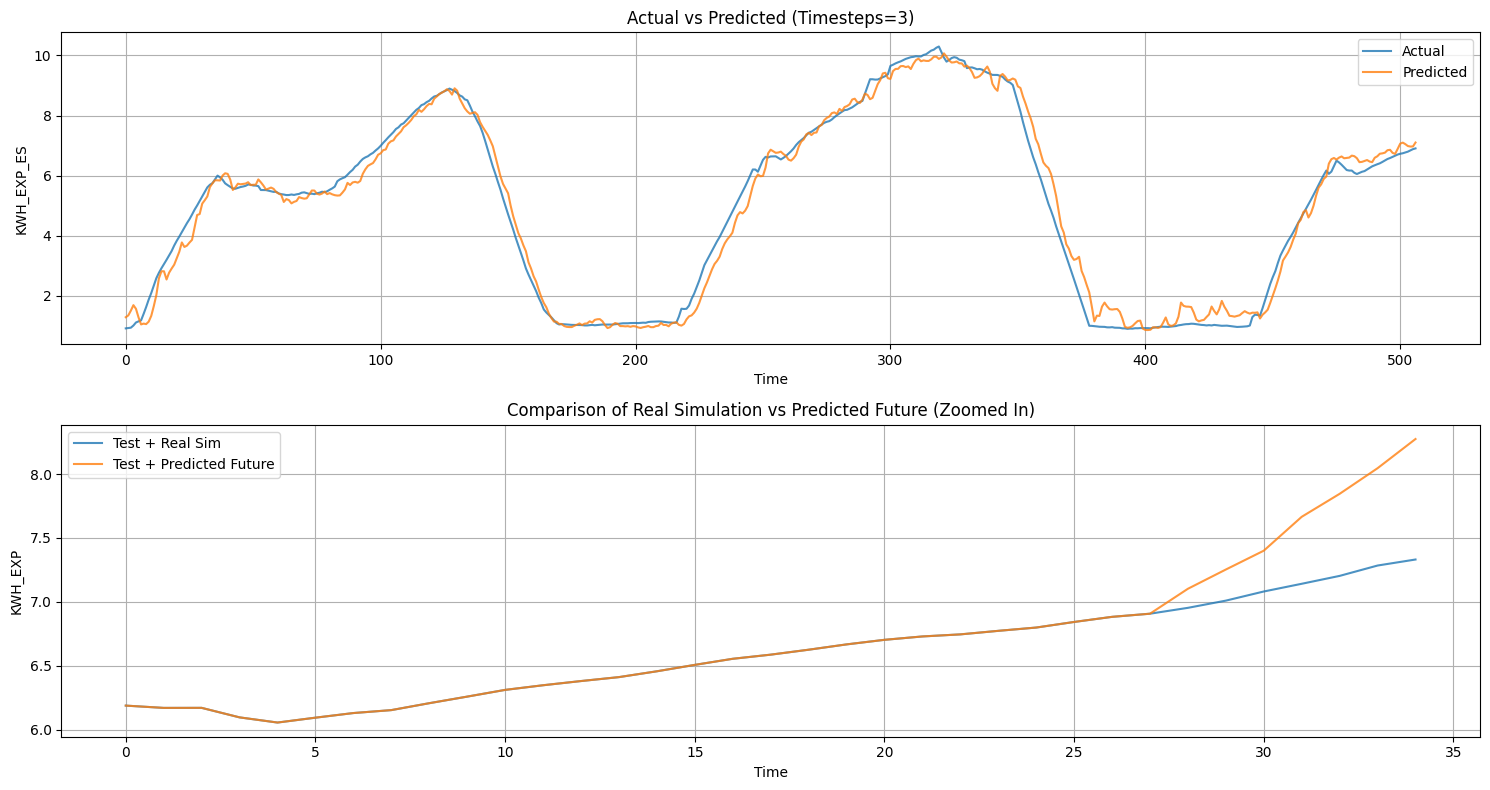


Metrics for timesteps=3:
MSE: 0.1568
R²: 0.9825
MAPE: 0.1158
MAE: 0.3031
Training time for timesteps = 3: 5.06 seconds

Training model with selected features and timesteps = 4
Epoch 14: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Results saved to lstm_timestep_4_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


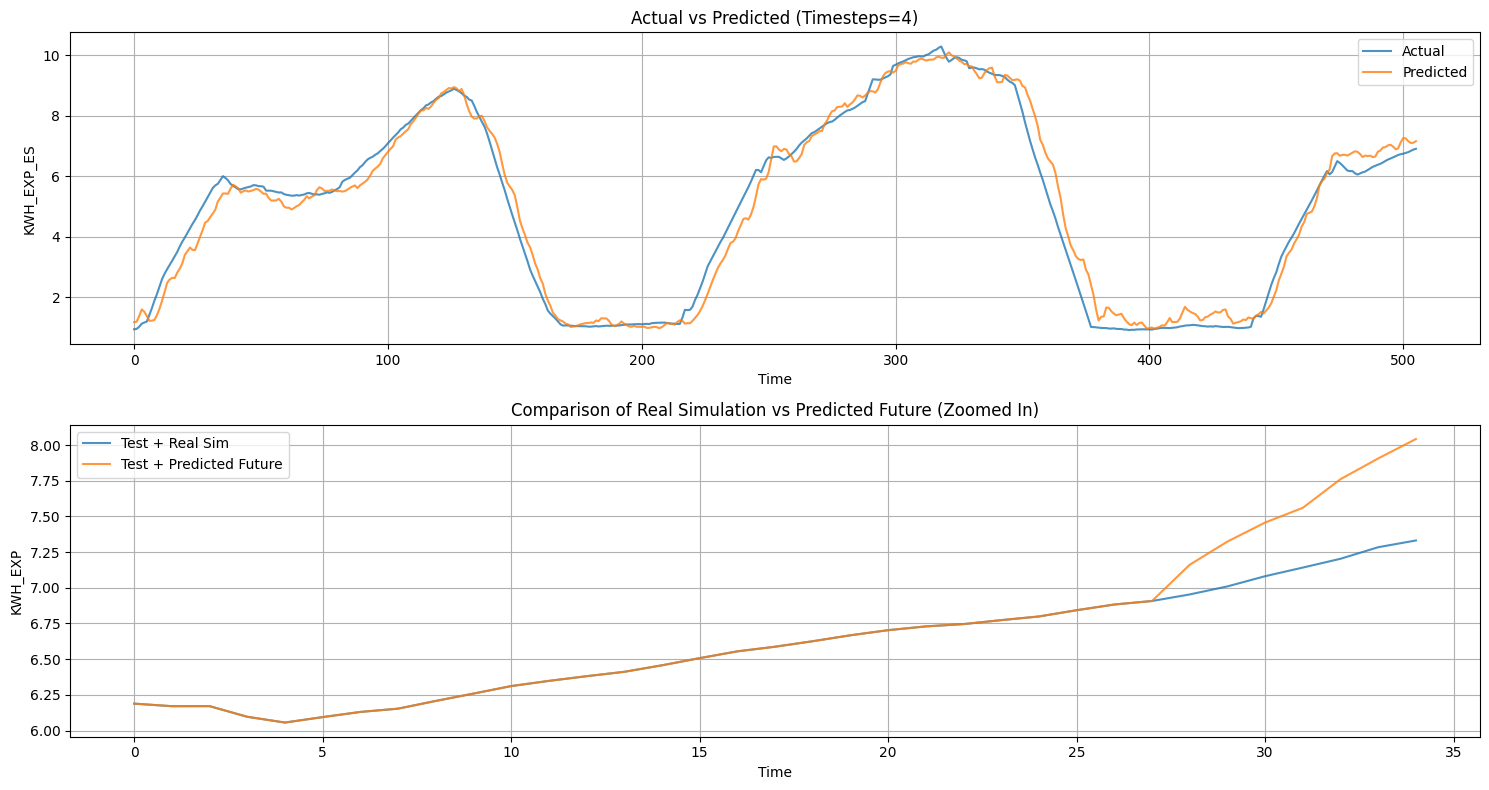


Metrics for timesteps=4:
MSE: 0.2299
R²: 0.9743
MAPE: 0.1271
MAE: 0.3650
Training time for timesteps = 4: 6.14 seconds

Training model with selected features and timesteps = 5
Epoch 13: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Results saved to lstm_timestep_5_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


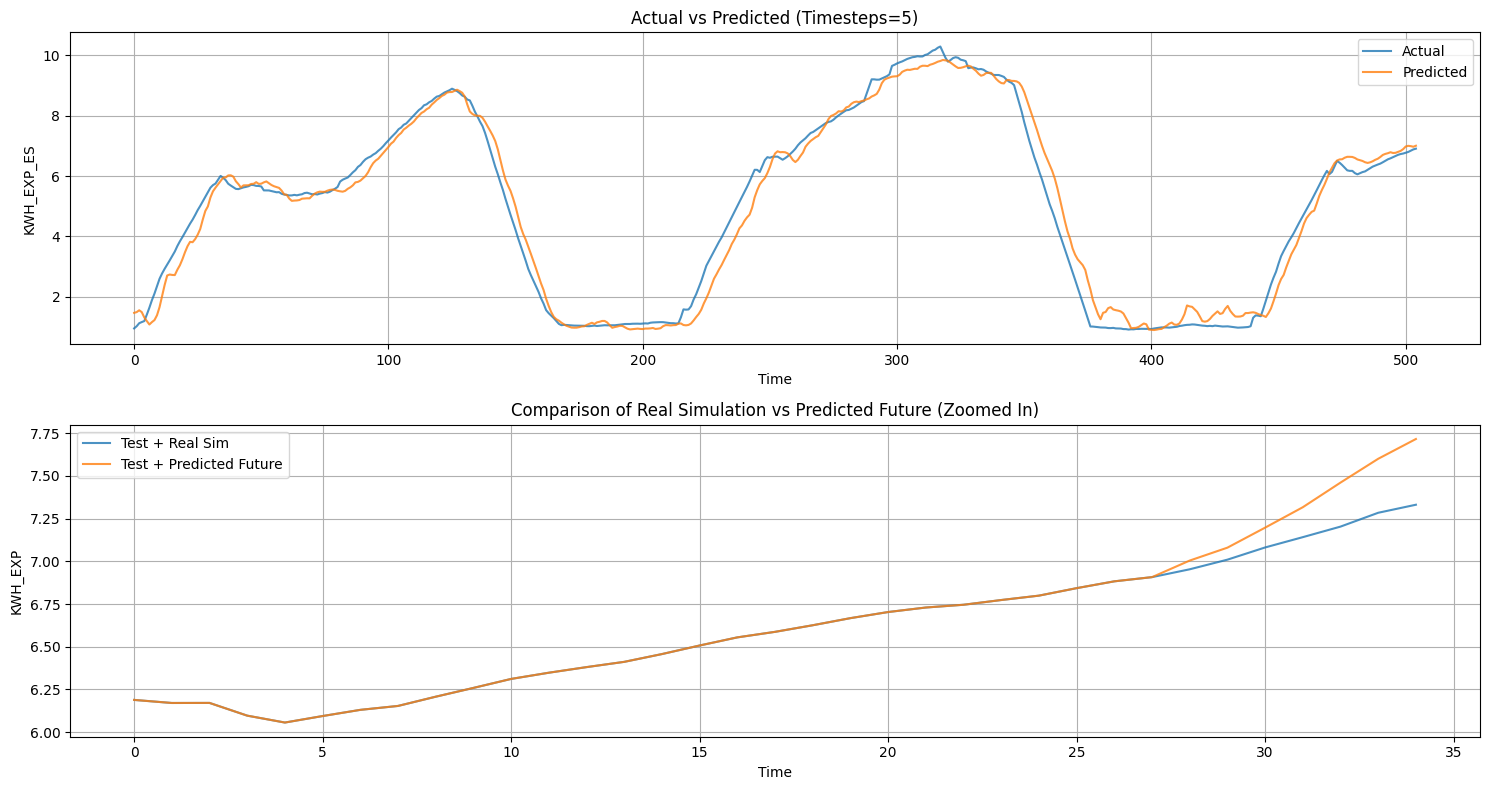


Metrics for timesteps=5:
MSE: 0.2325
R²: 0.9740
MAPE: 0.1312
MAE: 0.3653
Training time for timesteps = 5: 5.29 seconds

Training model with selected features and timesteps = 6
Epoch 12: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Results saved to lstm_timestep_6_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


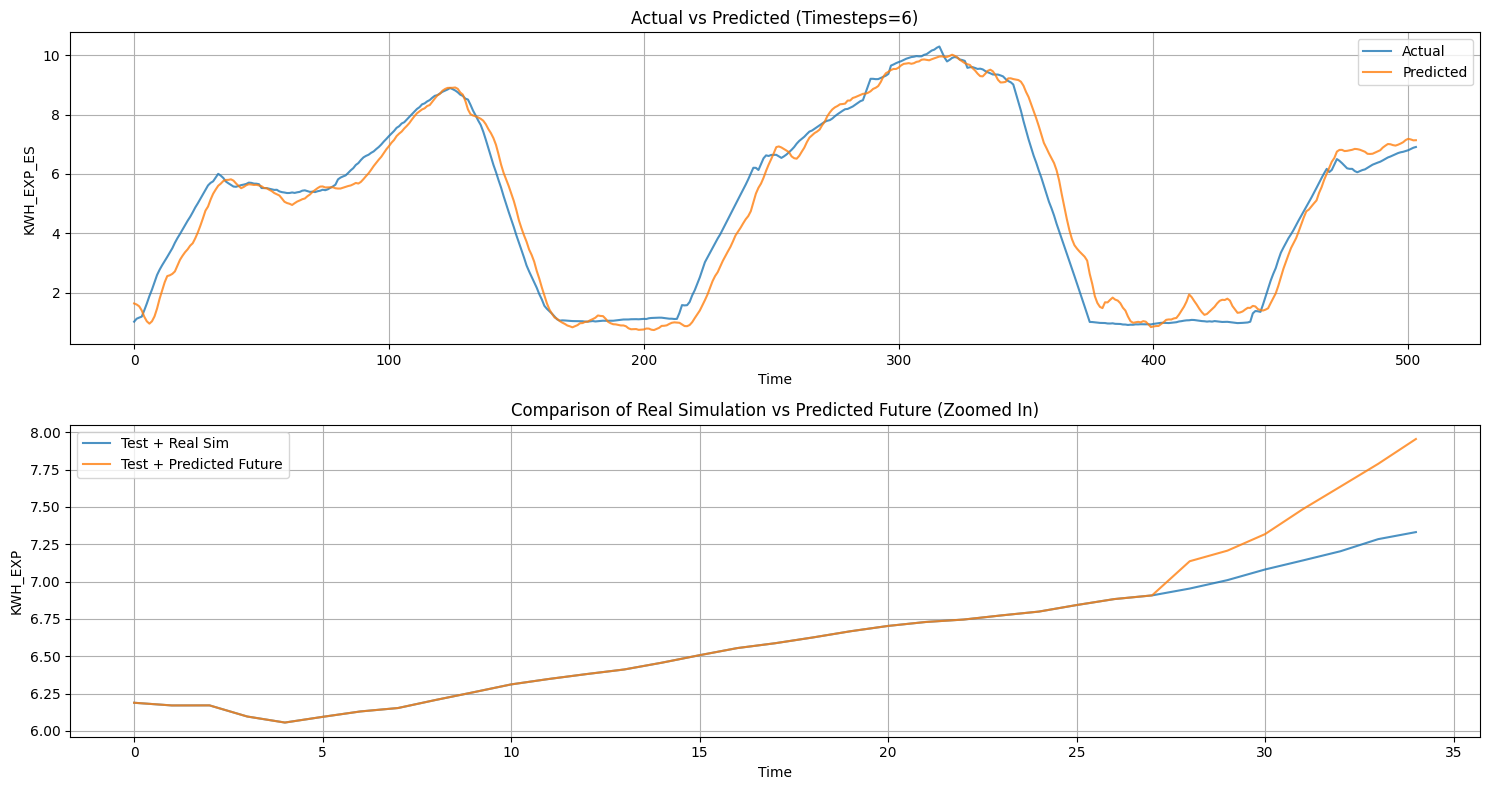


Metrics for timesteps=6:
MSE: 0.3521
R²: 0.9606
MAPE: 0.1659
MAE: 0.4437
Training time for timesteps = 6: 5.81 seconds

Training model with selected features and timesteps = 7
Epoch 11: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Results saved to lstm_timestep_7_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


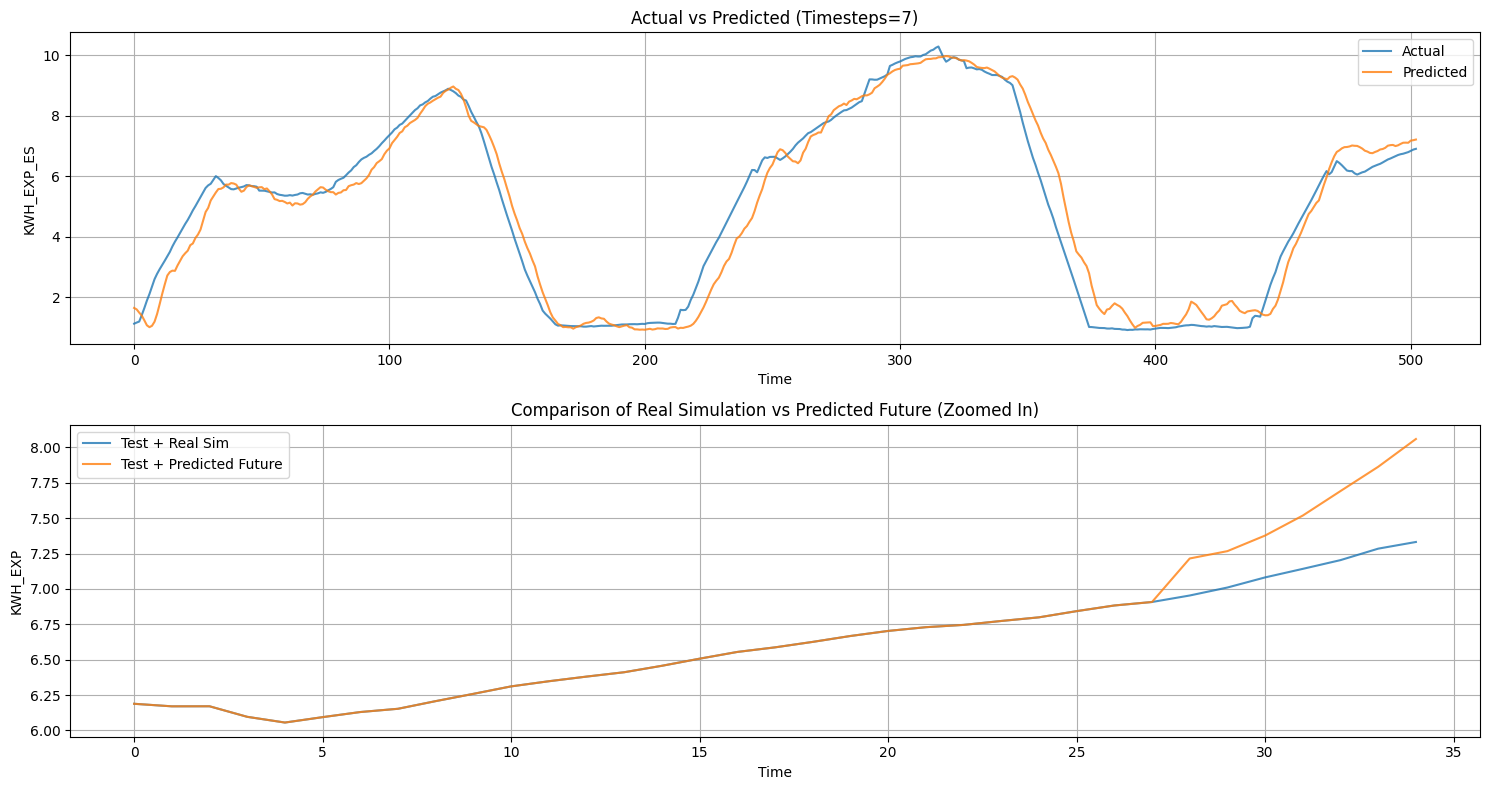


Metrics for timesteps=7:
MSE: 0.4373
R²: 0.9510
MAPE: 0.1764
MAE: 0.4917
Training time for timesteps = 7: 4.82 seconds
Total training execution time: 40.40 seconds


In [77]:
# Integrate with existing training scheme
total_training_start_time = time.time()
for ts in timesteps_list:
    print(f"\nTraining model with selected features and timesteps = {ts}")
    training_start_time = time.time()
    train_and_plot_lstm(train_scaled_features, train_scaled_target.ravel(), test_scaled_features, test_scaled_target.ravel(), ts, real_sim)
    training_end_time = time.time()
    print(f"Training time for timesteps = {ts}: {training_end_time - training_start_time:.2f} seconds")

total_training_end_time = time.time()
print(f"Total training execution time: {total_training_end_time - total_training_start_time:.2f} seconds")